In [2]:
import sys
import sklearn

assert sys.version_info >= (3, 5)

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

assert sklearn.__version__ >= "0.20"

import numpy as np
import os

np.random.seed(17)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

784
5


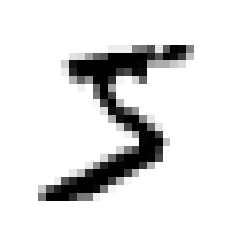

In [12]:
X, y = mnist["data"], mnist["target"]
X.shape
# Each image is 28 * 28 pixels
print(X[0].size)
print(y[0])

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [17]:
y = y.astype(np.uint8)
print(y[0])

TRAIN_SET_NUM = 60000
X_train, X_test, y_train, y_test = (
    X[:TRAIN_SET_NUM],
    X[TRAIN_SET_NUM:],
    y[:TRAIN_SET_NUM],
    y[TRAIN_SET_NUM:],
)


5


In [19]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=17)
sgd_clf.fit(X_train, y_train_5)

ret = sgd_clf.predict([some_digit])
assert ret == [[True]]


# Performance Evaluation

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
for train_index, test_index in skfolds.split(X_train, y_train_5):
	clone_clf = clone(sgd_clf)
	X_train_folds = X_train[train_index]
	y_train_folds = y_train_5[train_index]
	X_test_fold = X_train[test_index]
	y_test_fold = y_train_5[test_index]

	clone_clf.fit(X_train_folds, y_train_folds)
	y_pred = clone_clf.predict(X_test_fold)
	n_correct = sum(y_pred == y_test_fold)
	print(n_correct / len(y_pred))

0.92
0.9648
0.9658


In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96675, 0.9618 , 0.94425])

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_train_5, y_train_pred)
print(conf_mat)

[[53936   643]
 [ 1901  3520]]


In [44]:
from sklearn.metrics import precision_score, recall_score

prec_score = precision_score(y_train_5, y_train_pred)
print(prec_score)
reca_score = recall_score(y_train_5, y_train_pred)
print(reca_score)

from sklearn.metrics import f1_score
f1_score = f1_score(y_train_5, y_train_pred)
print(f"f1 score: {f1_score}")

0.8455440787893346
0.6493266924921601
f1 score: 0.7345575959933222


In [45]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


In [46]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown
    plt.axis([-50000, 50000, 0, 1])  # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# plt.figure(figsize=(8, 4))  # Not shown
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.plot(
#     [threshold_90_precision, threshold_90_precision], [0.0, 0.9], "r:"
# )  # Not shown
# plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  # Not shown
# plt.plot(
#     [-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:"
# )  # Not shown
# plt.plot([threshold_90_precision], [0.9], "ro")  # Not shown
# plt.plot(
#     [threshold_90_precision], [recall_90_precision], "ro"
# )  # Not shown                                           # Not shown
# plt.show()


In [47]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)


# plt.figure(figsize=(8, 6))
# plot_precision_vs_recall(precisions, recalls)
# plt.plot([recall_90_precision, recall_90_precision], [0.0, 0.9], "r:")
# plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
# plt.plot([recall_90_precision], [0.9], "ro")

# plt.show()


In [49]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

y_train_pred_90 = y_scores >= threshold_90_precision

ret = precision_score(y_train_5, y_train_pred_90)
print(f"Precision: {ret}")

ret = recall_score(y_train_5, y_train_pred_90)
print(f"Recall: {ret}")

1854.5025990559493
Precision: 0.9001214329083181
Recall: 0.5469470577384247
